In [1]:
import kagglehub
import pytesseract
from PIL import Image
import requests
import pandas as pd
from transformers import AutoProcessor, BlipForConditionalGeneration
from IPython.display import display
import os

# Download latest version
path = kagglehub.dataset_download("akuppps/dankmemes-reddit-top-comments")

print("Path to dataset files:", path)

100%|██████████| 99.6k/99.6k [00:00<00:00, 177kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/akuppps/dankmemes-reddit-top-comments/versions/1


In [2]:
tessdata_dir = "/usr/share/tesseract-ocr/4.00/tessdata/"
os.makedirs(tessdata_dir, exist_ok=True)

url = "https://github.com/tesseract-ocr/tessdata/raw/main/eng.traineddata"

traineddata_path = os.path.join(tessdata_dir, "eng.traineddata")

response = requests.get(url)
with open(traineddata_path, "wb") as f:
    f.write(response.content)

In [3]:
os.environ["TESSDATA_PREFIX"] = "/usr/share/tesseract-ocr/4.00/tessdata/"
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

In [4]:
df = pd.read_csv(f"{path}/dankmemes_Top_Comments.csv")

In [5]:
df.sample(10)

,Unnamed: 0,title,score,id,url,comms_num,created,body,timestamp
1444,1444,Comment,1,i39a7do,NaN,0,1.649013e+09,"I cant remember what I was watching, but it wa...",2022-04-03 15:10:43
859,859,mfw m*ds dont remove this,3011,ts0f7d,https://i.redd.it/g1aqx8xrwgq81.gif,21,1.648623e+09,NaN,2022-03-30 02:48:25
1500,1500,Comment,3,i396ow3,NaN,0,1.649012e+09,"Then another admin was, there were some of the...",2022-04-03 14:46:12
1550,1550,Comment,32,i39550u,NaN,0,1.649011e+09,what does cheating in a gigantic canvas have t...,2022-04-03 14:35:14
1396,1396,Comment,5,i39dkth,NaN,0,1.649014e+09,i'm white and i've been stopped by the TSA for...,2022-04-03 15:33:22
185,185,They do be like that,21742,tjxa62,https://i.redd.it/qg242h06yvo81.gif,60,1.647933e+09,NaN,2022-03-22 03:15:17
1120,1120,Comment,1,i39s01w,NaN,0,1.649020e+09,What’s a tile,2022-04-03 17:14:23
1687,1687,Comment,2,i390chm,NaN,0,1.649009e+09,They are taking over our world. Also fun fact:...,2022-04-03 14:02:23
634,634,The Double Standards of Water,5917,tejxh2,https://i.redd.it/t906bm9m8in81.png,44,1.647332e+09,NaN,2022-03-15 04:05:00
531,531,That's why i don't use it during the break,7725,tif0z6,https://i.redd.it/8kh2v31ugho81.gif,15,1.647758e+09,NaN,2022-03-20 02:32:56


In [6]:
len(df["title"])

1898

In [7]:
df.isna().sum()

Unnamed: 0      0
title           0
score           0
id              0
url           899
comms_num       0
created         0
body          999
timestamp       0
dtype: int64

In [8]:
df.dropna(subset=["url"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 998
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  999 non-null    int64  
 1   title       999 non-null    object 
 2   score       999 non-null    int64  
 3   id          999 non-null    object 
 4   url         999 non-null    object 
 5   comms_num   999 non-null    int64  
 6   created     999 non-null    float64
 7   body        0 non-null      object 
 8   timestamp   999 non-null    object 
dtypes: float64(1), int64(3), object(5)
memory usage: 78.0+ KB


In [9]:
urls = df.url

In [10]:
urls[1:9]

1    https://i.redd.it/cmem70sowcm81.gif
2    https://i.redd.it/5kxyntrizhm81.gif
3    https://i.redd.it/p4rc3d0yl1q81.jpg
4    https://i.redd.it/ycsi7qy775q81.gif
5    https://i.redd.it/70uum4rpxll81.gif
6    https://i.redd.it/fepe187jfjn81.gif
7    https://i.redd.it/to10s17e2bp81.gif
8    https://i.redd.it/z3i1fbc6kfq81.gif
Name: url, dtype: object

In [27]:
import json

def extract_text(url):
    image = Image.open(requests.get(url, stream=True).raw)
    display(image.resize((250,250)))
    text = pytesseract.image_to_string(image)
    return text


def image_to_text(url):
    processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    image = Image.open(requests.get(url, stream=True).raw)
    text = "A picture of"
    
    inputs = processor(images=image, text=text, return_tensors="pt")
    
    outputs = model.generate(**inputs)
    caption = processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
    return caption


import json

def generate_caption(extracted_text, text_from_image):
    prompt = f"""You are a humorous meme caption generator. Generate only one caption for this text extracted from the meme: "{extracted_text}" 
    and this description of the image: "{text_from_image}" """

    response = requests.post("http://ollama:11434/api/generate", json={
        "model": "mistral",
        "prompt": prompt
    })

    if response.status_code == 200:
        try:
            lines = response.text.strip().split('\n')
            full_response = ""
            for line in lines:
                data = json.loads(line)
                full_response += data.get('response', '')
            return full_response.strip()
        except Exception as e:
            return f"Error parsing response: {e}"
    else:
        return f"Error: {response.status_code} - {response.text}"



In [28]:
def pipeline(url):
    extracted_text = extract_text(url)
    text_from_image = image_to_text(url)
    generated_caption = generate_caption(extracted_text, text_from_image)
    return generated_caption

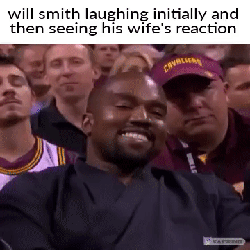

Caption:  "When Will Smith thought he was among friends, but then realized he wasn't hiding his love for emojis."


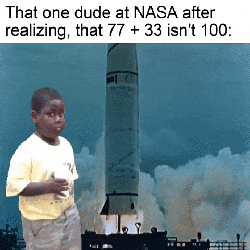

Caption:  "When you're used to launching galaxies, but can't even add two numbers correctly."


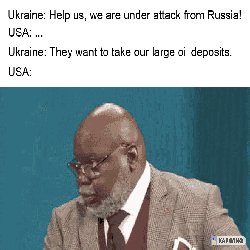

Caption:  "When you realize even the most well-dressed gentleman can't always come to your rescue when it comes to international politics."


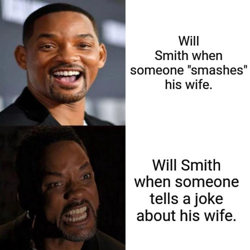

Caption:  "Will Smith when you crack a harmless joke about his favorite sitcom character..."


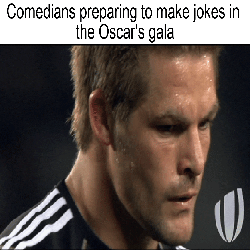

Caption:  "Wait, I thought the Oscars were about movies, not penalties on goal!"


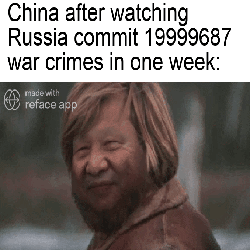

Caption:  "China, casually scrolling through TikTok with a smirk, thinking 'And I thought my week was busy!'"


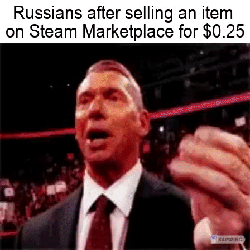

Caption:  "When you're Russian and just made half a dollar on Steam... Time to treat yourself to a new suit!"


In [30]:
for i in range(7):
    captions = pipeline(urls[i])
    print("Caption: ",captions)